In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2 
import tensorflow as tf
import pydicom
from sklearn.model_selection import train_test_split
import joblib

2023-05-17 01:07:00.125471: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 01:07:00.126995: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 01:07:00.160554: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 01:07:00.161128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 01:07:00.762733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
def read_csv_data(path_to_file):
    """
    Reads the CSV file and returns a list of lists containing the data
    """
    X = []
    Y = []
    with open(path_to_file, 'r') as f:
        data = f.readlines()
    for i in range(len(data)):
        csv_data = data[i].split(';')
        y_value = 1 if csv_data[1] == '1\n' else 0
        X.append(csv_data[0])
        Y.append(y_value)
    return np.array(X), np.array(Y)

In [5]:
csv_info = read_csv_data('data/dental_base.csv')

In [6]:
csv_info

(array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
        '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
        '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
        '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
        '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
        '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
        '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
        '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
        '101', '102', '103', '104', '105', '106', '107', '108', '109',
        '110', '111', '112', '113', '114', '115', '116', '117', '118',
        '119', '120', '121', '122', '123', '124', '125', '126', '127',
        '128', '129', '130', '131', '132', '133', '134', '135', '136',
        '137', '138', '139', '140', '141', '142', '1

In [7]:
def read_all_train_images(folder_path, csv_info):
    """
    Reads all the images in the folder and returns a list of images
    """
    num_files = len(csv_info[0])
    images_np = np.zeros((num_files, 100, 100), dtype=np.uint8)
    valid_indices = [] 

    for i, filename in enumerate(csv_info[0]):
        img_path = os.path.join(folder_path, f"{filename}.jpg")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (100, 100))
        images_np[i] = img
        img = img.flatten()
        if np.std(img) != 0:
            valid_indices.append(i)
    print(f"Number of valid images: {len(valid_indices)}")
    print(len(images_np))
    X = images_np[valid_indices]
    Y = csv_info[1][valid_indices]
    return X, Y


In [8]:
X, Y = read_all_train_images('data/photos', csv_info)

Number of valid images: 942
942


In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

In [10]:
x_train = x_train.reshape(x_train.shape[0], -1)
print(x_train.shape)

(753, 10000)


In [11]:
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_test.shape)

(189, 10000)


In [12]:
def normalize_data(data):
    mean_of_each_image = data.mean(axis=0)
    data_normalized = data - mean_of_each_image
    # data_normalized /= np.std(data, axis=0)
    return data_normalized

In [13]:
def pca(data, h, w, approximation=0.85):
    # normalize the data
    data_normalized = normalize_data(data)
    #Find the covariance matrix
    print("Step 1")
    covariance_matrix = np.cov(data_normalized, rowvar=False)
    #Find the eigenvalues and eigenvectors of the covariance matrix
    print("Step 2")
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    print("Step 3")
    #Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    print("Step 4")

    #Find the number of principal components that explain the given approximation
    total_variance = np.sum(eigenvalues)
    variance_explained = eigenvalues / total_variance
    cumulative_variance_explained = np.cumsum(variance_explained)
    number_of_components = np.argmax(cumulative_variance_explained >= approximation) + 1
    #Find the principal components
    print("Step 6")
    principal_components = eigenvectors[:, :number_of_components]
    return principal_components, data_normalized, number_of_components, cumulative_variance_explained

In [14]:
def transform_data(data, principal_components):
    data_normalized = normalize_data(data)
    return data_normalized.dot(principal_components)

In [15]:
principal_components, data_normalized, number_of_components, cumulative_variance_explained = pca(x_train, 100, 100, 0.85)


Step 1
Step 2
Step 3
Step 4
Step 6


In [16]:
with open("./model_data/principal_components.npy", "wb") as f:
    np.save(f, principal_components)

In [17]:
final_data_normalized_reduced = transform_data(x_train, principal_components)

In [18]:
final_data_normalized_reduced

array([[-1182.00782332,  -901.74880496,  2340.77651556, ...,
           77.35230046,   150.79749328,   -57.53528648],
       [ 1220.9467442 ,   530.36695332,   832.11972719, ...,
          -52.37898331,  -159.97690071,    23.62813625],
       [ -474.30630594, -1017.73987673,  -769.28981728, ...,
           -3.03525956,   -51.85126455,    33.53750363],
       ...,
       [ -196.67190158,  -828.72801207,  -634.43903009, ...,
          139.7576273 ,    81.61573799,   -75.39960784],
       [ 1305.49178441,  -182.33595323,   537.63950291, ...,
           44.04750516,   -44.26926218,    63.55828765],
       [ 1572.49065681,   469.63143465, -1077.08383015, ...,
         -104.13066276,    33.23139307,    73.33816648]])

In [19]:
number_of_components

131

In [20]:
x_train.shape


(753, 10000)

In [21]:
final_data_normalized_reduced.shape


(753, 131)

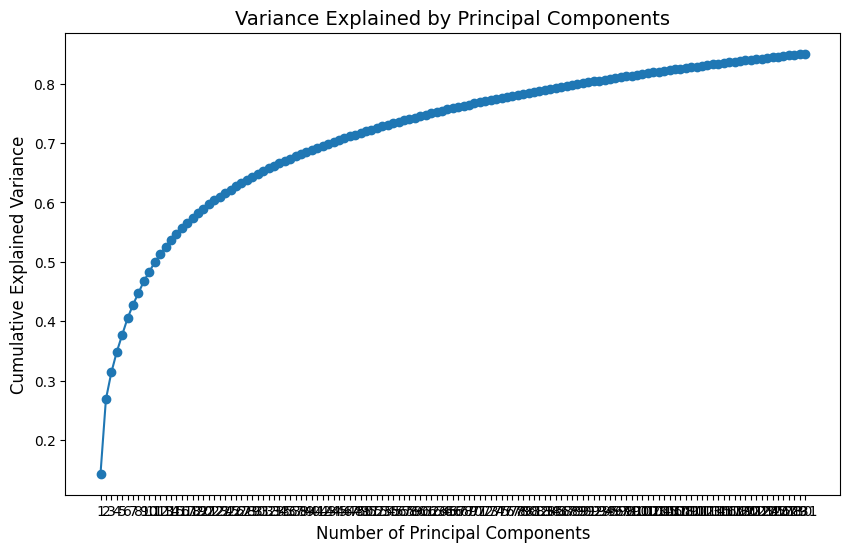

In [22]:
def plot_variance_explained(cumulative_variance_explained, number_of_components):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, number_of_components + 1), cumulative_variance_explained[:number_of_components], '-o')
    plt.xticks(np.arange(1, number_of_components + 1))
    plt.xlabel('Number of Principal Components', fontsize=12)
    plt.ylabel('Cumulative Explained Variance', fontsize=12)
    plt.title('Variance Explained by Principal Components', fontsize=14)
    plt.show()

plot_variance_explained(cumulative_variance_explained, number_of_components)


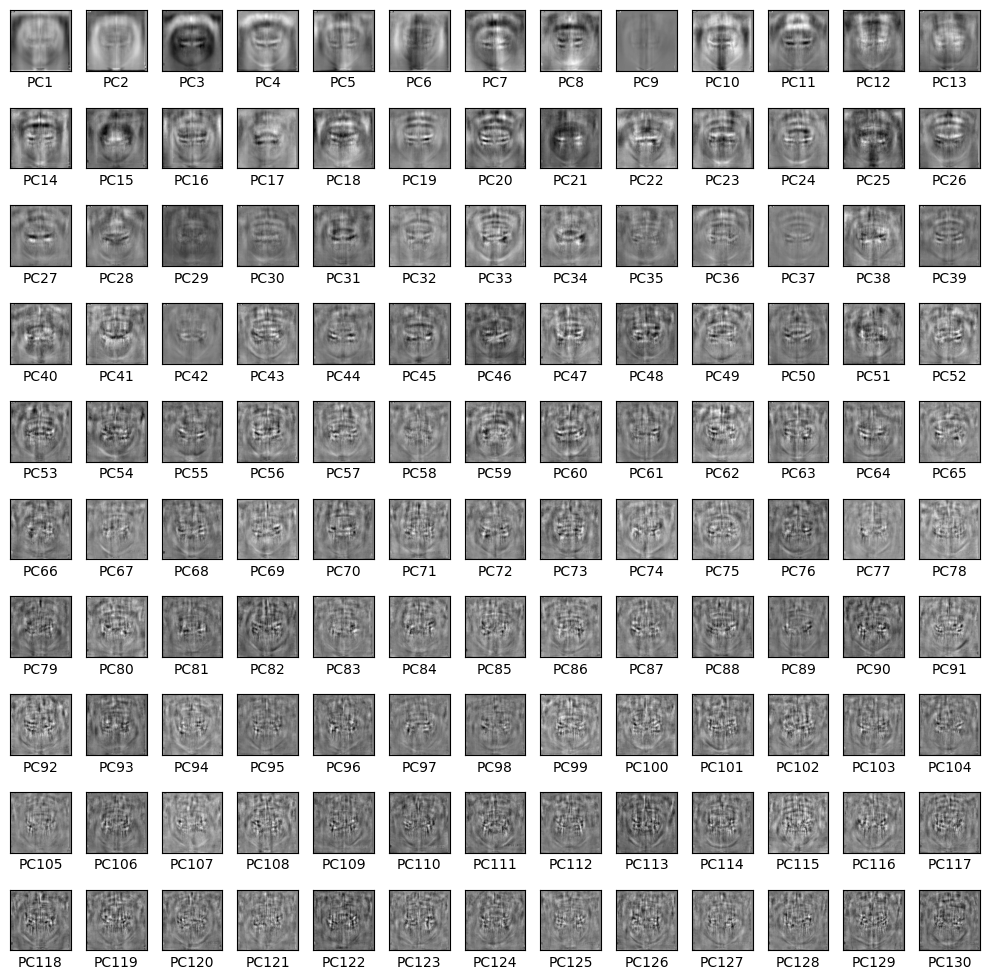

In [23]:
def plot_principal_components(principal_components, im_shape=(100, 100), n_row=10, n_col=None):
    if n_col is None:
        n_col = principal_components.shape[1] // n_row

    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 10))
    axes = axes.ravel()

    for i, axi in enumerate(axes):
        if i < principal_components.shape[1]:
            img = principal_components[:, i].reshape(im_shape)
            axi.imshow(img, cmap="gray")
            axi.set_xlabel(f"PC{i+1}")
            axi.set_xticks([])
            axi.set_yticks([])
        else:
            axi.axis('off')

    plt.tight_layout()
    plt.show()

plot_principal_components(principal_components)


In [24]:
final_data_normalized_reduced_x_test = transform_data(x_test, principal_components)

In [25]:
final_data_normalized_reduced_x_test

array([[-1.47713804e+03, -1.30741057e+03, -6.51141896e+01, ...,
        -8.44627722e+01,  1.61493077e+01,  2.04535613e+01],
       [-5.32809654e+02, -1.23923517e+03, -1.15510113e+02, ...,
         2.60818140e+01,  1.87568740e+01,  3.71144622e+01],
       [-2.73723947e+03,  3.67014768e+03,  1.09679805e+02, ...,
        -1.78686427e+01, -6.68965562e+01, -1.79568989e+02],
       ...,
       [ 4.45186464e+02, -3.02295645e+02, -3.03268822e+01, ...,
         1.26403808e+02,  2.82524629e+00, -1.31282598e+02],
       [-2.01110695e+03, -1.68180636e+03,  3.15471031e+02, ...,
         1.72585318e+01, -1.26480016e+02, -5.42076987e+01],
       [-1.13155038e+01, -1.12230748e+03, -1.38304027e+02, ...,
        -2.80401339e+01,  9.95200139e+00,  2.31074741e+01]])

In [73]:
def evaluate_model(predicted, true):
    sum = 0
    for i in range(len(predicted)):
        if predicted[i] == true[i]:
            sum+=1
    return sum/len(predicted)

In [74]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(final_data_normalized_reduced, y_train)

DecisionTreeClassifier()

In [75]:
joblib.dump(dtc, 'model_data/decission_tree.pkl')

['model_data/decission_tree.pkl']

In [76]:
y_pred = dtc.predict(final_data_normalized_reduced_x_test)

In [77]:
evaluate_model(y_pred, y_test)

0.6825396825396826

In [78]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(final_data_normalized_reduced, y_train)
y_pred = rfc.predict(final_data_normalized_reduced_x_test)

In [79]:
joblib.dump(rfc, 'model_data/Random_Forest.pkl')

['model_data/Random_Forest.pkl']

In [80]:
evaluate_model(y_pred, y_test)

0.6984126984126984

In [81]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(final_data_normalized_reduced, y_train)
y_pred = svc.predict(final_data_normalized_reduced_x_test)

In [82]:
joblib.dump(svc, 'model_data/svc.pkl')

['model_data/svc.pkl']

In [83]:
evaluate_model(y_pred, y_test)

0.7354497354497355

In [84]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(final_data_normalized_reduced, y_train)
y_pred = knn.predict(final_data_normalized_reduced_x_test)

In [85]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [56]:
evaluate_model(y_pred, y_test)

0.6772486772486772

In [57]:
joblib.dump(knn, 'model_data/KNeighbors.pkl')


['model_data/KNeighbors.pkl']

In [61]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2 
import tensorflow as tf
import joblib

def normalize_data(data):
    mean_of_each_image = data.mean(axis=0)
    data_normalized = data - mean_of_each_image
    # data_normalized /= np.std(data, axis=0)
    return data_normalized

def transform_data(data, principal_components):
    data_normalized = normalize_data(data)
    return data_normalized.dot(principal_components)


def run(img_pathes):
    images_np = np.zeros((len(img_pathes), 100, 100), dtype=np.uint8)
    for i in range(len(img_pathes)):
        img = cv2.imread(img_pathes[i], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (100, 100))
        images_np[i] = img
    
    # principal_components = np.load('model_data/principal_components.npy')

    images_np = images_np.reshape(images_np.shape[0], -1)

    img_transformed = transform_data(images_np, principal_components)
    print(knn.predict(img_transformed))
run("static/2.jpg")

[ WARN:0@717.309] global loadsave.cpp:244 findDecoder imread_('s'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
